In [1]:
import sys
sys.path.append('../')

from seamcarving.carver import fastCarver
from skimage import io
from scipy.signal import medfilt2d

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm
import numpy as np

import numba
import scipy

In [2]:
img = io.imread('../test_seamcarving/img/swimmer.jpg')

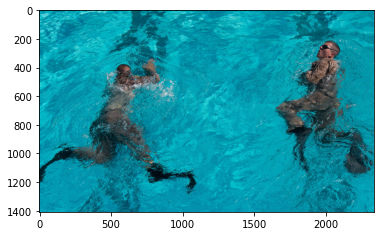

In [3]:
plt.imshow(img)
plt.show()

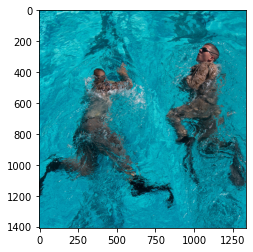

In [11]:
#don't support multicolumns removal yet, so do it jankaly by creating a new object everytime

new_img = img.copy()
cols_removed = 1000

for _ in tqdm(range(cols_removed)):
    carver = fastCarver(new_img)
    mask = carver.seam_mask()
    r,c = mask.shape
    new_img=new_img[np.stack([mask]*3,axis=2)].reshape([r,c-1,3])
    
plt.imshow(new_img)
plt.show()

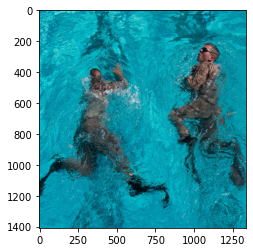

In [12]:
#slightly faster but with issues by using the same energy

new_img = img.copy()
cols_removed = 1000
carver = fastCarver(new_img)
E_raw = carver.calc_energy()

E=E_raw.copy()

for _ in tqdm(range(cols_removed)): 
    mask = carver.seam_mask(E.copy())
    r,c = mask.shape
    E=E[mask].reshape((r,c-1))
    new_img=new_img[np.stack([mask]*3,axis=2)].reshape([r,c-1,3])

plt.imshow(new_img)
plt.show()

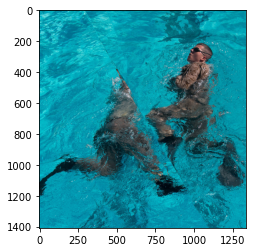

In [6]:
#even faster and w5ith more issues by using the same energy and backtrack

@numba.jit(nopython=True)
def edit_backrtrack(inds:np.ndarray,B:np.ndarray):
    for i,j in inds:
        if i>0:
            l = B[i,:]
            for v,f in enumerate(l>=j):
                if f:
                    B[i,v]-=1



#slightly faster by using the same energy
new_img = img.copy()
cols_removed = 1000
carver = fastCarver(new_img)
E_raw = carver.calc_energy()
E,B  = carver.forward_pass(energy=E_raw.copy())


for _ in tqdm(range(cols_removed)): 
    mask = carver.seam_mask(E.copy(),B.copy())
    r,c = mask.shape
    E=E[mask].reshape((r,c-1))
    B=B[mask].reshape((r,c-1))
    edit_backrtrack(np.argwhere(~mask),B)
    new_img=new_img[np.stack([mask]*3,axis=2)].reshape([r,c-1,3])

plt.imshow(new_img)
plt.show()